# Face Recognition using PCA, LDA, and Deep Learning
This project explores various face recognition techniques including **Principal Component Analysis (PCA)**, **Linear Discriminant Analysis (LDA)**, and a basic **Deep Learning (DL)** approach for classification. We will load the AT&T face dataset, preprocess it, apply dimensionality reduction techniques, and evaluate their performance.

## 1. Data Loading and Preprocessing
In this section, we:
- Load the AT&T Face Dataset
- Resize images to a consistent size
- Flatten them into vectors suitable for ML/DL models
- Split the dataset into training and testing sets

# **Face Recognition Using PCA & LDA**


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Generate the Data Matrix and the Label vector


In [ ]:
paths = ["/kaggle/input/att-database-of-faces/s" + str(i) for i in range(1, 41)]
cnt = 0
Data = np.zeros((400, 10304))
labels = np.zeros((400, 1))
for i in range(40):
    labels[i * 10 : (i + 1) * 10] = i + 1
for path in paths:
    files = os.listdir(path)
    for file in files:
        img = Image.open(path + "/" + file)
        np_img = np.array(img)
        np_img = np_img.flatten()
        Data[cnt] = np_img
        cnt += 1

## 2. PCA (Principal Component Analysis)
We apply PCA to reduce dimensionality while retaining as much variance as possible. This helps improve computational efficiency and can enhance classification performance.

### Data Visualization


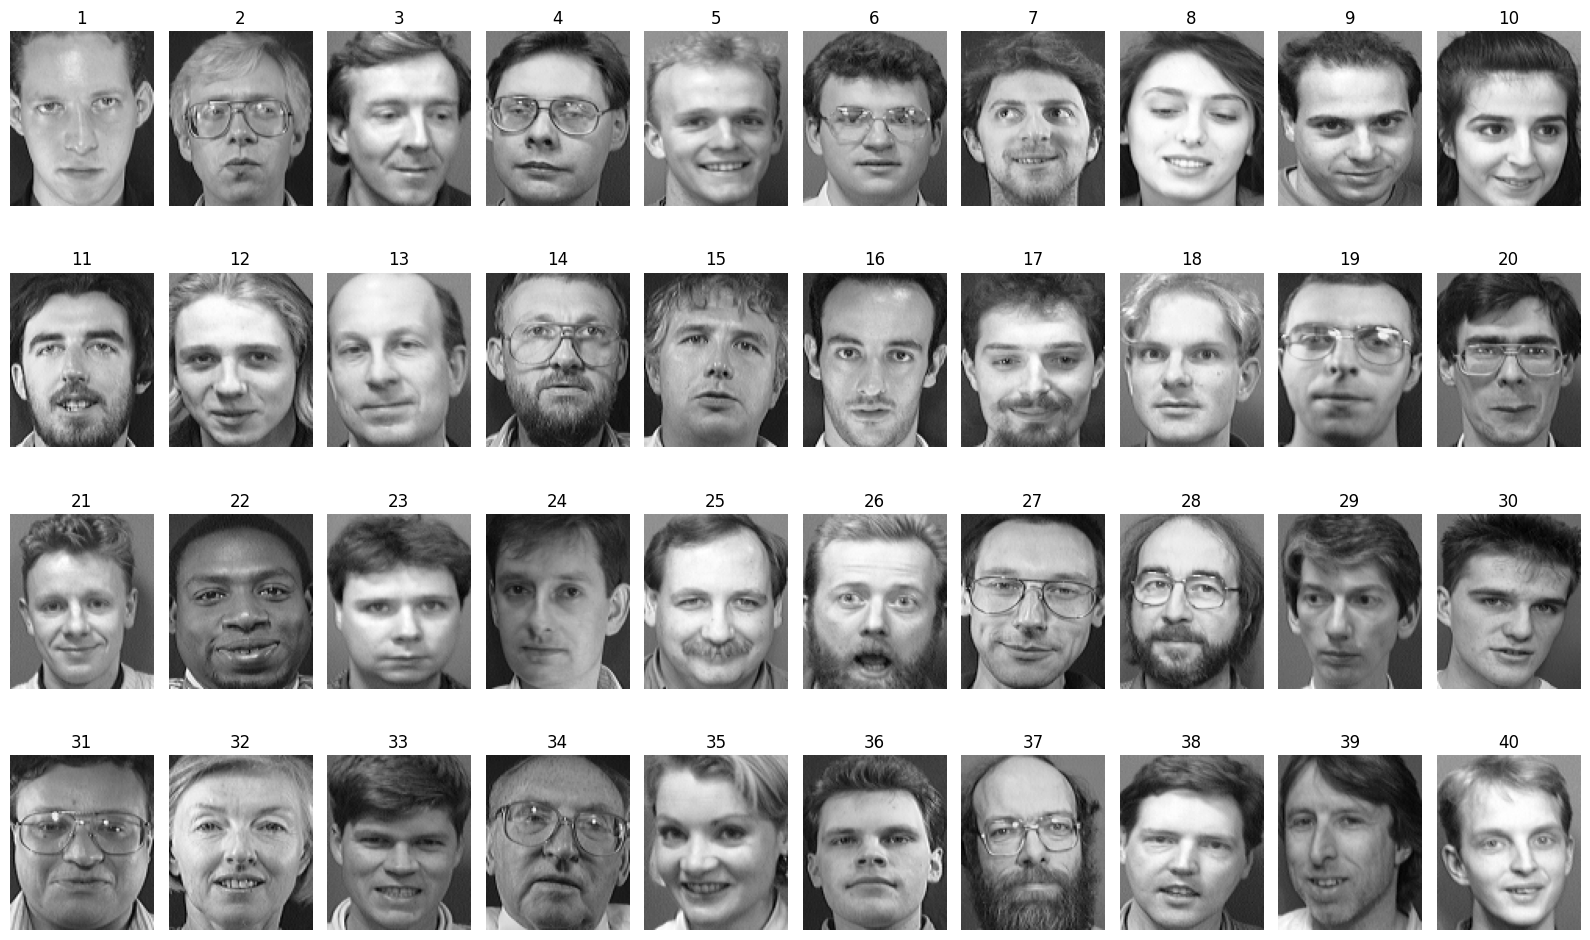

In [ ]:
image_height = 112
image_width = 92

fig, axs = plt.subplots(4, 10, figsize=(16, 10))

axs = axs.ravel()

for i in range(40):
    image_array = np.reshape(Data[(i) * 10], (image_height, image_width))
    axs[i].imshow(image_array, cmap="gray")
    axs[i].set_title(i + 1)
    axs[i].axis("off")

plt.tight_layout()
plt.show()

## Splitting The Dataset


In [ ]:
X_train = Data[0::2]
X_test = Data[1::2]
y_train = labels[0::2]
y_test = labels[1::2]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(200, 10304)
(200, 10304)
(200, 1)
(200, 1)


## 3. LDA (Linear Discriminant Analysis)
After PCA, we apply LDA to project the data into a lower-dimensional space that maximizes class separability. LDA is supervised and uses class labels to improve discrimination.

## PCA


In [ ]:
def get_PCA(training_data, alpha):
    mean_face = np.mean(training_data, axis=0)
    training_data_centralized = training_data - mean_face
    cov_matrix = training_data_centralized @ training_data_centralized.T
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    eigenvectors_converted = training_data_centralized.T @ eigenvectors
    eigenfaces = eigenvectors_converted / np.linalg.norm(eigenvectors_converted, axis=0)
    sum = 0
    no_components = 0
    for i in range(len(eigenvalues)):
        sum += eigenvalues[i]
        no_components += 1
        if sum / np.sum(eigenvalues) >= alpha:
            break
    return mean_face, eigenfaces[:, :no_components]


mean_face, eigenfaces = get_PCA(X_train, 0.8)
print(eigenfaces.shape)

(10304, 35)


## Projection training Data and Test data


In [ ]:
def PCA_Projected_data(training_data,testing_data,mean_face, eigenfaces):
    X_train_centered = training_data - mean_face
    X_train_projected = X_train_centered @ eigenfaces
    X_test_centered = testing_data - mean_face
    X_test_projected = X_test_centered @ eigenfaces
    return X_train_projected, X_test_projected

## 4. Deep Learning Model
We define a simple neural network using Keras to classify faces based on raw pixel values or PCA/LDA-transformed features. The model includes dense layers with ReLU activation and a softmax output layer.

## Plotting The first 5 Eigen Faces


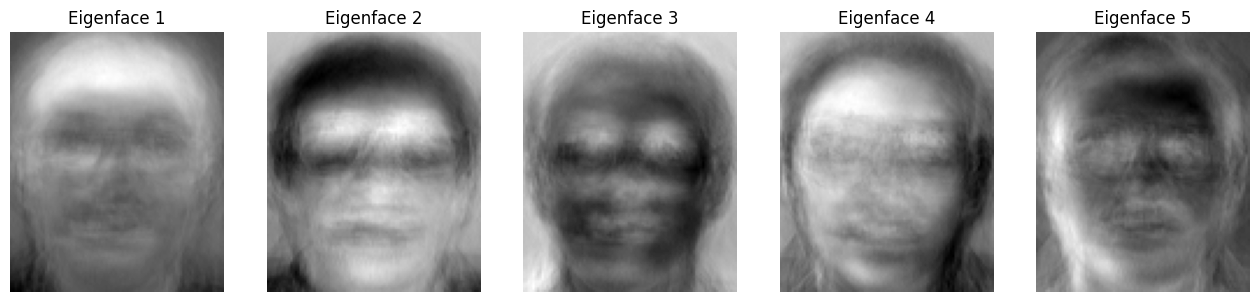

In [ ]:
_, eigenfaces = get_PCA(X_train, 0.95)
fig, axs = plt.subplots(1, 5, figsize=(16, 10))
for i in range(5):
    image_array = np.reshape(eigenfaces[:, i], (image_height, image_width))
    axs[i].imshow(image_array, cmap="gray")
    axs[i].set_title("Eigenface " + str(i + 1))
    axs[i].axis("off")

### Test PCA


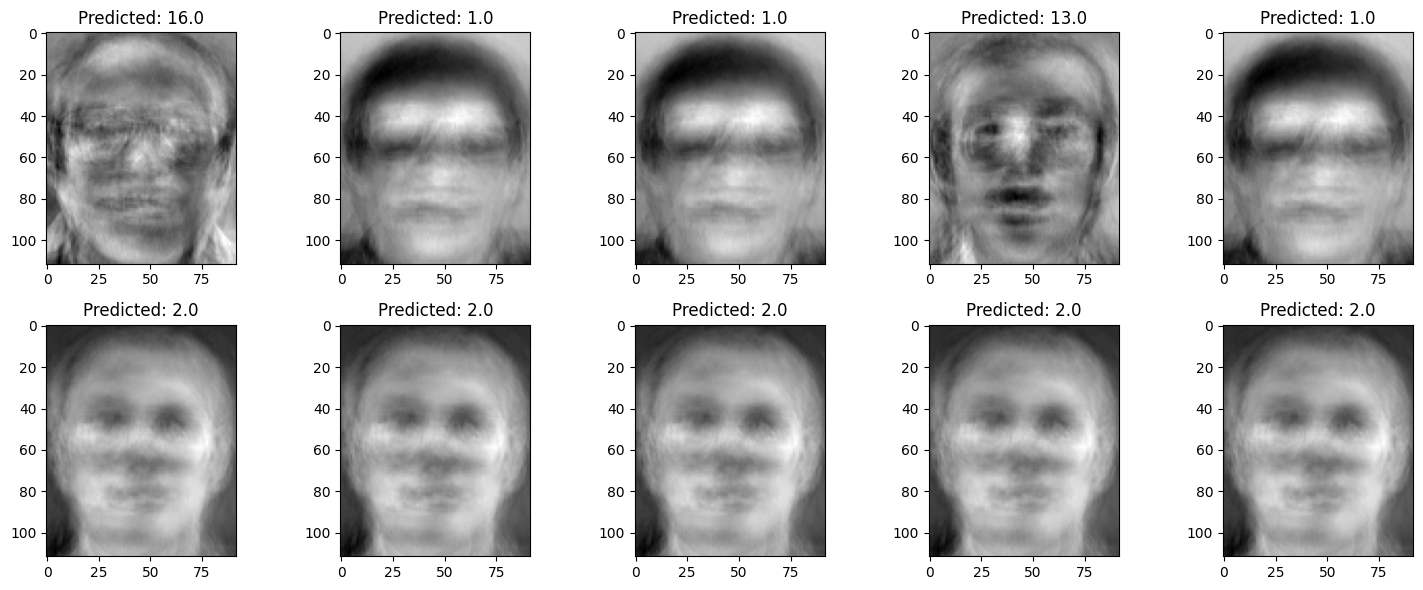

PCA Accuracy: 0.955


In [ ]:
import matplotlib.pyplot as plt

def Test_PCA(training_data, testing_data, training_labels, testing_labels, alpha, k):
    mean_face, eigenfaces = get_PCA(training_data, alpha)
    X_train_pca, X_test_pca = PCA_Projected_data(training_data, testing_data, mean_face, eigenfaces)
    knn = KNeighborsClassifier(k, weights="distance")
    knn.fit(X_train_pca, training_labels.ravel())
    y_pred = knn.predict(X_test_pca)
    accuracy = accuracy_score(testing_labels, y_pred.ravel())

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        image_array = np.reshape(eigenfaces[:, int(y_pred[i])], (image_height, image_width))
        ax.imshow(image_array, cmap="gray")  # Corrected from axs[i]
        ax.set_title(f'Predicted: {y_pred[i]}')

    plt.tight_layout()
    plt.show()

    return accuracy

accuracy = Test_PCA(X_train, X_test, y_train, y_test, 0.85, 1)
print("PCA Accuracy: " + str(accuracy))

## 5. Model Evaluation and Accuracy Comparison
We evaluate performance using accuracy metrics and compare PCA + LDA-based methods vs the deep learning model. Visualizations and print statements show insights into how well each approach performs.

## Classifier Tuning for PCA


In [ ]:
alphas = [0.8, 0.85, 0.9, 0.95]
k_values = [1, 3, 5, 7, 9]
df = pd.DataFrame(index=alphas, columns=k_values)
for num_dominant_eigen_vectors in alphas:
    for k in k_values:
        accuracy = Test_PCA(X_train,X_test,y_train,y_test,num_dominant_eigen_vectors, k)
        df.loc[num_dominant_eigen_vectors, k] = accuracy

df

,1,3,5,7,9
0.80,0.945,0.92,0.895,0.905,0.88
0.85,0.955,0.935,0.915,0.895,0.875
0.90,0.955,0.925,0.91,0.89,0.87
0.95,0.96,0.92,0.9,0.89,0.875


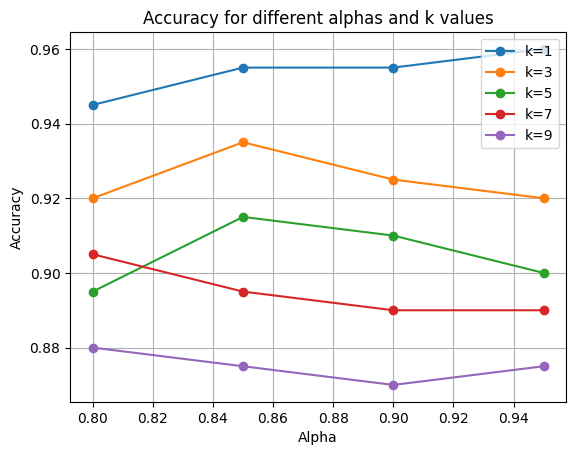

In [ ]:
for k in k_values:
    plt.plot(df.index, df[k], marker="o", label=f"k={k}")

plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Accuracy for different alphas and k values")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

## LDA


In [ ]:
def get_LDA(X_train, y_train):
    y_train = np.squeeze(y_train)
    class_means = np.array([np.mean(X_train[y_train == i], axis=0) for i in range(1, 41)])
    class_sizes = np.array([np.sum(y_train == i) for i in range(1, 41)])

    overall_mean = np.mean(X_train, axis=0)

    S_W = np.zeros((X_train.shape[1], X_train.shape[1]))
    for i in range(1, 41):
        class_data = X_train[y_train == i]
        centered_data = class_data - class_means[i - 1]
        S_W += np.dot(centered_data.T, centered_data)

    S_W += 1e-7 * np.identity(X_train.shape[1])

    S_B = np.zeros((X_train.shape[1], X_train.shape[1]))
    for i in range(1, 41):
        class_data = X_train[y_train == i]
        class_diff = class_means[i - 1] - overall_mean
        S_B += class_sizes[i - 1] * np.outer(class_diff, class_diff)

    eigenvalues, eigenvectors = np.linalg.eig(np.dot(np.linalg.inv(S_W), S_B))

    idx = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, idx]

    projection_matrix = sorted_eigenvectors[:, :39]
    return np.real(projection_matrix)

## The Projection Matrix of LDA


In [ ]:
LDA_projection_matrix = get_LDA(X_train,y_train)
print(LDA_projection_matrix.shape)

(10304, 39)


## LDA Projection


In [ ]:
def LDA_projected_data(training_data,test_data,projection_matrix):
    projected_X_train = np.dot(training_data, projection_matrix)
    projected_X_test = np.dot(test_data, projection_matrix)
    return projected_X_train, projected_X_test

### Test LDA


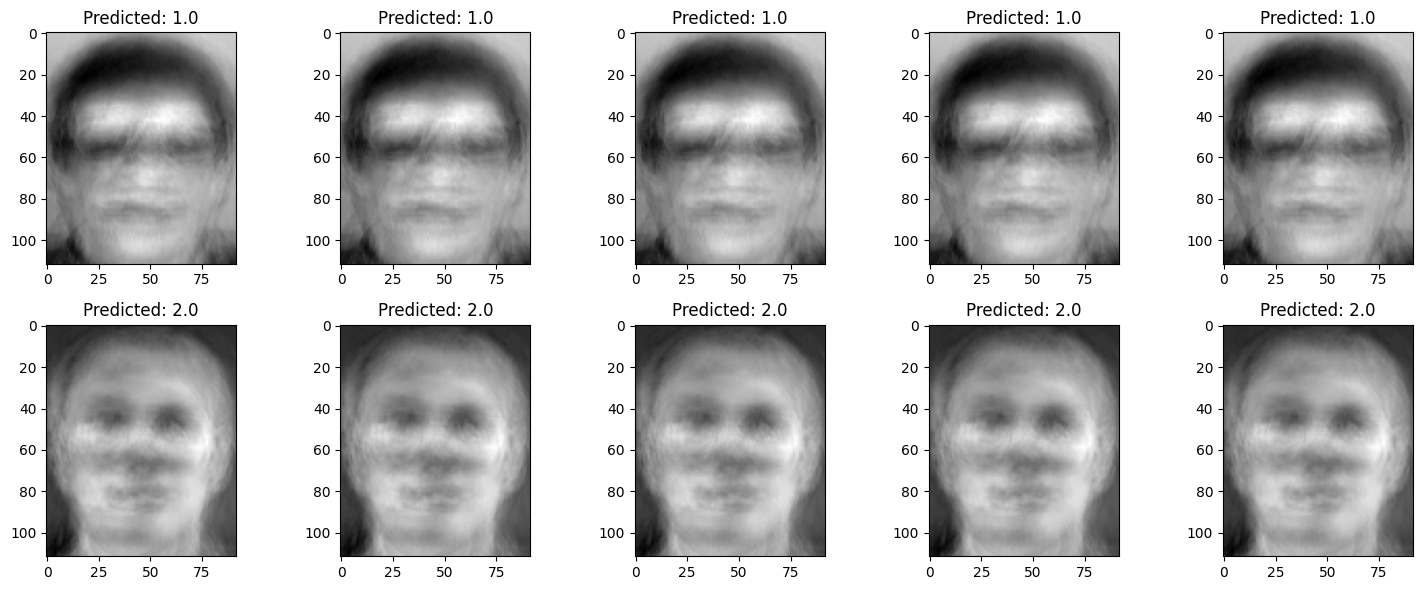

LDA Accuracy: 0.985


In [ ]:
def Test_LDA(k):
    projected_X_train, projected_X_test = LDA_projected_data(X_train,X_test,LDA_projection_matrix)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(projected_X_train, y_train.ravel())
    y_pred = knn.predict(projected_X_test)
    accuracy = accuracy_score(y_test, y_pred.ravel())

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        image_array = np.reshape(eigenfaces[:, int(y_pred[i])], (image_height, image_width))
        ax.imshow(image_array, cmap="gray")  # Corrected from axs[i]
        ax.set_title(f'Predicted: {y_pred[i]}')

    plt.tight_layout()
    plt.show()

    return accuracy

print("LDA Accuracy: " + str(Test_LDA(1)))

## Classifier Tuning for LDA


In [ ]:
k_values = [1, 3, 5, 7, 9]

results = []
projected_X_train, projected_X_test = LDA_projected_data(X_train,X_test,LDA_projection_matrix)
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights="distance")
    knn.fit(projected_X_train, y_train.ravel())
    y_pred = knn.predict(projected_X_test)
    accuracy = accuracy_score(y_test, y_pred.ravel())
    results.append({"accuracy": accuracy})

df = pd.DataFrame(results, index=k_values)
df.index.name = "k"
df

,accuracy
k,
1,0.985
3,0.985
5,0.985
7,0.985
9,0.985


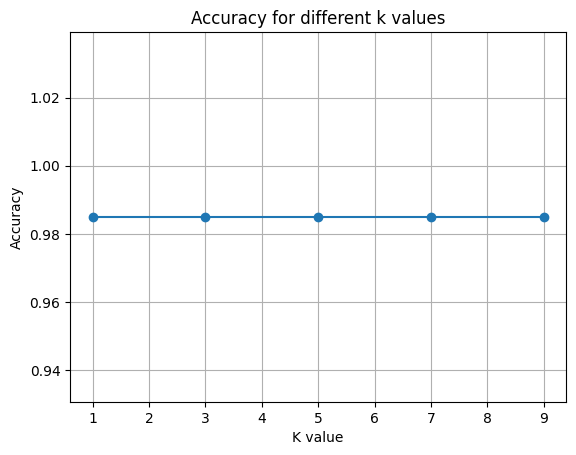

In [ ]:
plt.plot(df, marker="o")
plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k values")
plt.grid(True)
plt.show()

## Comparison Between PCA & LDA


### Accuracy of PCA VS LDA with respect to K (number of nearest neighbours)


In [ ]:
alpha = [0.8, 0.85, 0.9, 0.95]
k_values = [1, 3, 5, 7, 9]
variants = [
    "PCA α = 0.8",
    "PCA α = 0.85",
    "PCA α = 0.9",
    "PCA α = 0.95",
    "LDA",
]
df = pd.DataFrame(index=variants, columns=k_values)
for num_dominant_eigen_vectors in alphas:
    for k in k_values:
        for i in range(4):
            pca_accuracy = Test_PCA(X_train,X_test,y_train,y_test,alpha[i], k)
            df.loc[variants[i], k] = str(pca_accuracy * 100) + "%"
        lda_accuracy = Test_LDA(k)
        df.loc["LDA", k] = str(lda_accuracy * 100) + "%"
df

,1,3,5,7,9
PCA α = 0.8,94.5%,92.0%,89.5%,90.5%,88.0%
PCA α = 0.85,95.5%,93.5%,91.5%,89.5%,87.5%
PCA α = 0.9,95.5%,92.5%,91.0%,89.0%,87.0%
PCA α = 0.95,96.0%,92.0%,90.0%,89.0%,87.5%
LDA,98.5%,98.5%,98.5%,98.5%,98.5%


## Splitting Data 70% Train and 30% Test

In [ ]:
def split_data(data,labels):
    bonus_x_train = np.zeros((280,10304))
    bonus_x_test = np.zeros((120,10304))
    bonus_y_train = np.zeros((280,1))
    bonus_y_test = np.zeros((120,1))
    for  i in range (40):
        bonus_x_train[i*7:(i+1)*7] = data[i*10:i*10+7]
        bonus_x_test[i*3:(i+1)*3] = data[i*10+7:i*10+10]
        bonus_y_train[i*7:(i+1)*7] = labels[i*10:i*10+7]
        bonus_y_test[i*3:(i+1)*3] = labels[i*10+7:i*10+10]
    indices = np.arange(280)
    np.random.shuffle(indices)
    bonus_x_train = bonus_x_train[indices]
    bonus_y_train = bonus_y_train[indices]
    return bonus_x_train,bonus_x_test,bonus_y_train,bonus_y_test
bonus_x_train,bonus_x_test,bonus_y_train,bonus_y_test = split_data(Data,labels)

In [ ]:
bonus_x_train, bonus_x_test, bonus_y_train, bonus_y_test = split_data(Data, labels)


In [ ]:
mean_face, eigenfaces = get_PCA(bonus_x_train, 0.85)
X_train_pca, X_test_pca = PCA_Projected_data(bonus_x_train,bonus_x_test,mean_face, eigenfaces)
knn = KNeighborsClassifier(1, weights="distance")
knn.fit(X_train_pca, bonus_y_train.ravel())
y_pred = knn.predict(X_test_pca)
accuracy = accuracy_score(bonus_y_test, y_pred.ravel())
print("PCA Accuracy: " + str(accuracy))


PCA Accuracy: 0.9083333333333333


### Comparison Between Ordinary Split and Train Split in PCA

In [ ]:
alpha = [0.8, 0.85, 0.9, 0.95]
k=1
df = pd.DataFrame(index=alpha, columns=["Original Split", "Bonus Split"])
for num_dominant_eigen_vectors in alpha:
    pca_accuracy = Test_PCA(X_train,X_test,y_train,y_test,num_dominant_eigen_vectors, k)
    df.loc[num_dominant_eigen_vectors, "Original Split"] = pca_accuracy
    bonus_pca_accuracy = Test_PCA(bonus_x_train,bonus_x_test,bonus_y_train,bonus_y_test,num_dominant_eigen_vectors, k)
    df.loc[num_dominant_eigen_vectors, "Bonus Split"] = bonus_pca_accuracy
df

,Original Split,Bonus Split
0.80,0.945,0.908333
0.85,0.955,0.908333
0.90,0.955,0.916667
0.95,0.96,0.925


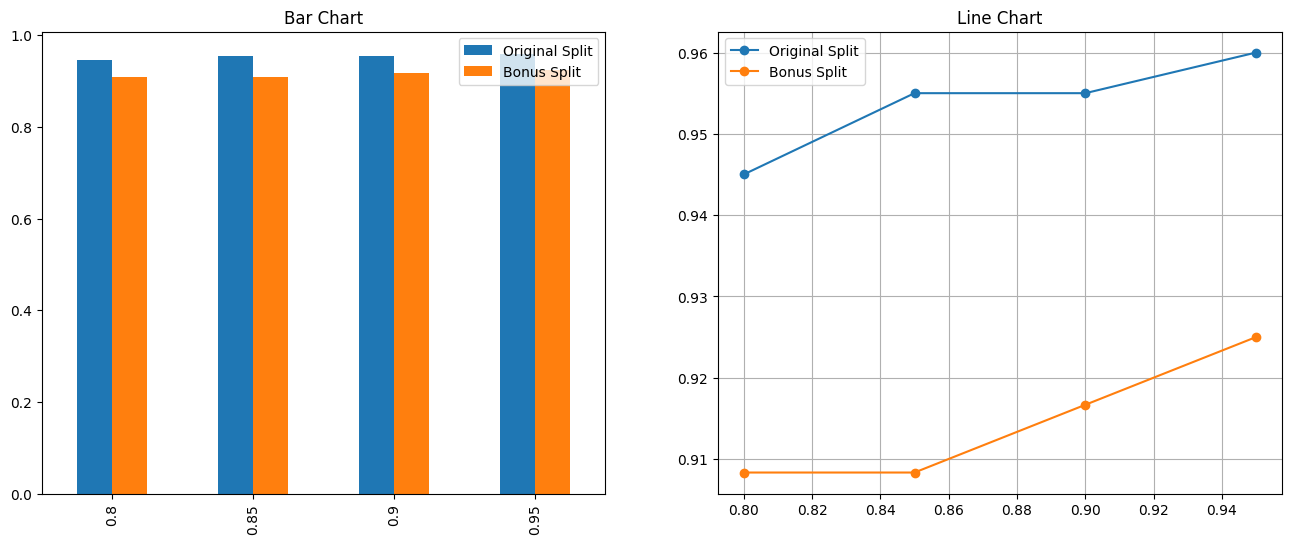

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
df.plot(kind="bar", ax=ax[0])
df.plot(kind="line", ax=ax[1], marker="o")
ax[0].set_title("Bar Chart")
ax[1].set_title("Line Chart")
plt.grid(True)
plt.show()

### Comparison Between Ordinary Split and Bonus Split in LDA

In [ ]:
def get_acc(X_train, X_test, y_train, y_test, k):
    knn = KNeighborsClassifier(k, weights="distance")
    knn.fit(X_train, y_train.ravel())
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred.ravel())
    return accuracy
Bonus_LDA_projection_matrix = get_LDA(bonus_x_train, bonus_y_train)
projected_X_train, projected_X_test = LDA_projected_data(bonus_x_train,bonus_x_test,LDA_projection_matrix)
acc_Lda_07 = get_acc(projected_X_train, projected_X_test, bonus_y_train, bonus_y_test, 1)
print("LDA Accuracy: " + str(acc_Lda_07))


LDA Accuracy: 0.9916666666666667


In [ ]:
df = pd.DataFrame(index=[], columns=["Original Split", "Bonus Split"])
df.loc["LDA", "Original Split"] = Test_LDA(1)
df.loc["LDA", "Bonus Split"] = acc_Lda_07
df

,Original Split,Bonus Split
LDA,0.985,0.991667


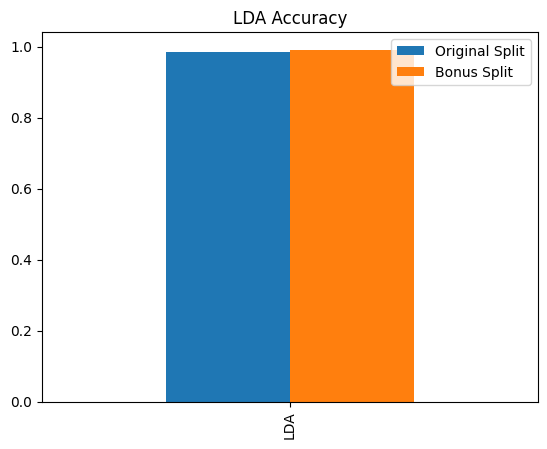

In [ ]:
df.plot(kind="bar")
plt.title("LDA Accuracy")
plt.show()

# **Face regcognition using DL**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
dataset_path = '/kaggle/input/att-database-of-faces'
dataset_faces = []
for person in range(1, 41):
    temp = []
    for pose in range(1, 11):
        image_path = f'{dataset_path}/s{person}/{pose}.pgm'
        image = plt.imread(image_path)
        temp.append(image)
    dataset_faces.append(np.array(temp))
dataset_faces = np.array(dataset_faces)

print('Total number of datasets:', len(dataset_faces))
print('Dataset size:', dataset_faces.shape)

Total number of datasets: 40
Dataset size: (40, 10, 112, 92)


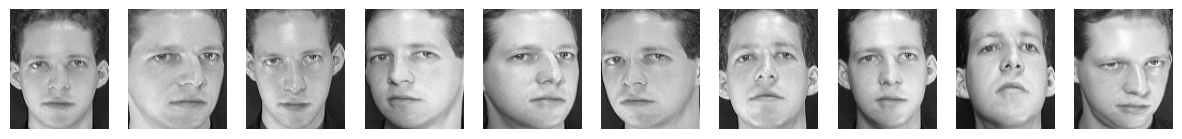

In [ ]:
def plot_images(images, n=10):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    plt.show()

plot_images(dataset_faces[0])

In [ ]:
num_subjects, num_images_per_subject, height, width = dataset_faces.shape
X = dataset_faces.reshape(num_subjects * num_images_per_subject, height, width, 1)
y = np.repeat(np.arange(num_subjects), num_images_per_subject)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

y_train = to_categorical(y_train, num_subjects)
y_test = to_categorical(y_test, num_subjects)
y_val = to_categorical(y_val, num_subjects)

In [ ]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(height, width, 1)),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_subjects, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=64)

Epoch 1/100
4/4 [==============================] - 8s 2s/step - loss: 3.6959 - accuracy: 0.0125 - val_loss: 3.7000 - val_accuracy: 0.0250
Epoch 2/100
4/4 [==============================] - 7s 2s/step - loss: 3.6733 - accuracy: 0.0542 - val_loss: 3.7111 - val_accuracy: 0.0625
Epoch 3/100
4/4 [==============================] - 6s 2s/step - loss: 3.6721 - accuracy: 0.0417 - val_loss: 3.7200 - val_accuracy: 0.0500
Epoch 4/100
4/4 [==============================] - 6s 2s/step - loss: 3.6647 - accuracy: 0.0583 - val_loss: 3.7260 - val_accuracy: 0.0500
Epoch 5/100
4/4 [==============================] - 6s 2s/step - loss: 3.6419 - accuracy: 0.0375 - val_loss: 3.7364 - val_accuracy: 0.0500
Epoch 6/100
4/4 [==============================] - 6s 2s/step - loss: 3.6457 - accuracy: 0.0583 - val_loss: 3.7383 - val_accuracy: 0.0250
Epoch 7/100
4/4 [==============================] - 7s 2s/step - loss: 3.6184 - accuracy: 0.0625 - val_loss: 3.7523 - val_accuracy: 0.0500
Epoch 8/100
4/4 [=================

In [ ]:
model.save('trained_model.keras')

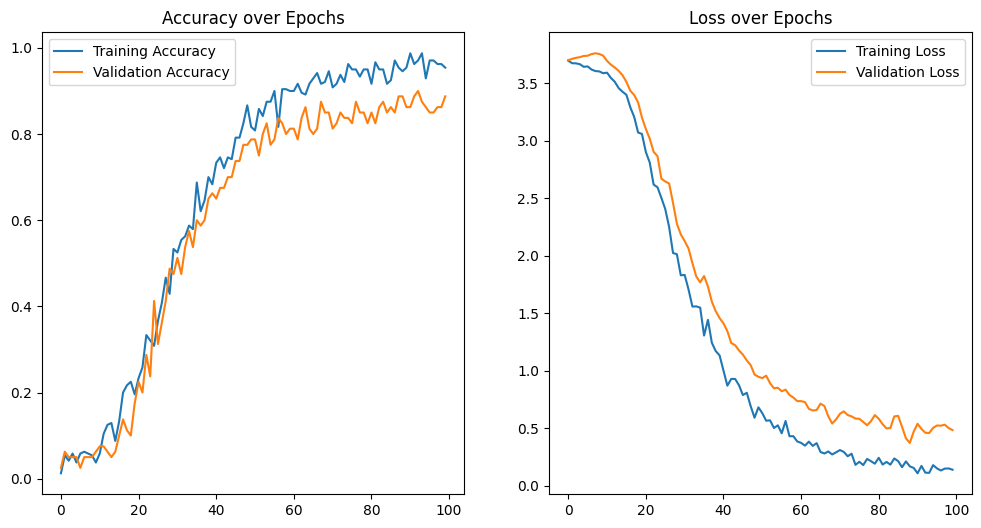

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(X_test)

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Loss:", loss)
print("Accuracy:", accuracy)

3/3 [==============================] - 1s 162ms/step
Loss: 0.40194669365882874
Accuracy: 0.887499988079071


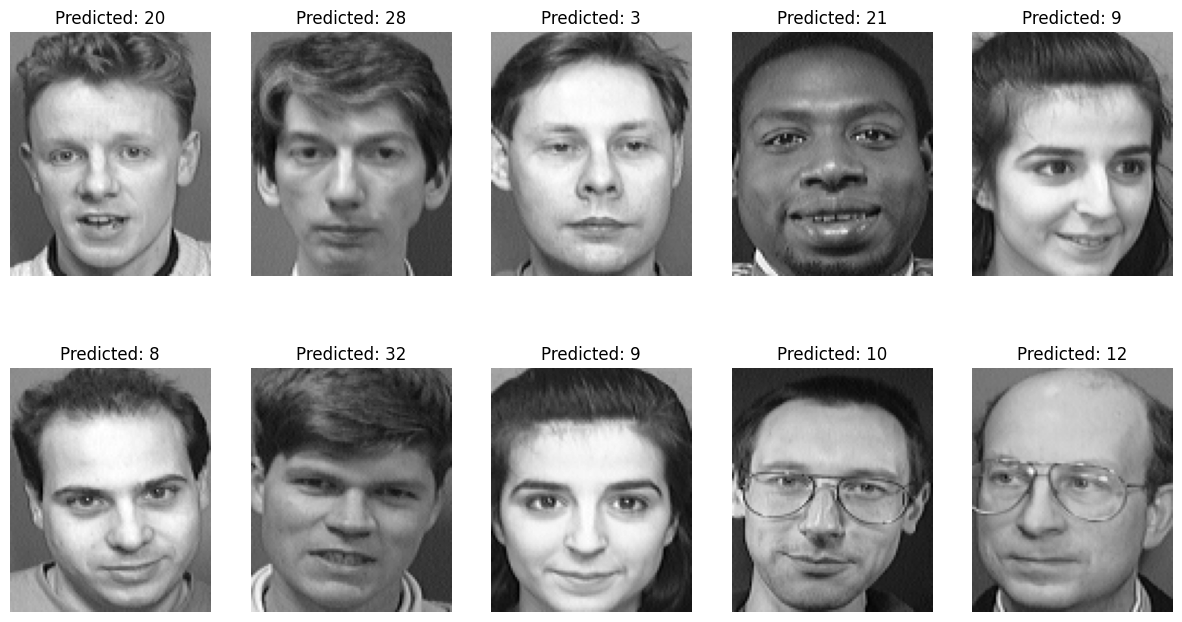

In [ ]:
predicted_labels = np.argmax(predictions, axis=1)

plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i].reshape(height, width), cmap='gray')
    plt.title(f'Predicted: {predicted_labels[i]}')
    plt.axis('off')
plt.show()